# Complexity-entropy plane construction

In [2]:
import os
import json
import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from adjustText import adjust_text
from tslearn.preprocessing import TimeSeriesScalerMinMax
from scipy.interpolate import make_interp_spline, BSpline

### Permutation Entropy

Энтропия перестановки — это энтропия Шеннона для распределения вероятностей, связанного с порядковыми (или перестановочными)
паттернами, оцененными с использованием скользящих разбиений по временному ряду. Это распределение вероятностей является так называемым порядковым распределением или распределением порядковых паттернов, а процесс символизации (т.е. замена значений порядковыми индексами), используемый для оценки этого распределения, представляет собой подход Бандта-Помпе.  

Чтобы описать этот процесс, рассмотрим произвольный временной ряд ${\{ x_{t}\}}_{t = 1,\ldots,N_{x}}$.
Сначала мы делим его на $n_{x} = N_{x} - (d_{x} - 1)\tau_{x}$ перекрывающихся раздела, состоящих из $d_{x} \geq 1$ наблюдений, разделенных временными интервалами $\tau_{x} \geq 1$.  

Для заданных значений $d_{x}$ и $\tau_{x}$, каждый раздел данных может быть представлен как $w_{p} = (x_{p},x_{p{+ \tau}_{x}},x_{p + 2\tau_{x}},\ldots,x_{p + (d_{x} - 2)\tau_{x}},x_{p + (d_{x} - 1)\tau_{x}})$, где $p = 1,\ldots,n_{x}$ индекс раздела. Параметры $d_{x}$ и $\tau_{x}$ являются единственными двумя параметрами метода Бандта-Помпе, где $d_{x}$ - размер эмбеддинга, а $\tau_{x}$ – лаг эмбеддинга.  

Затем для каждого раздела $w_{p}$ мы оцениваем перестановку $\pi_{p} = \left( r_{0},r_{1},\ldots,r_{d_{x} - 1} \right)$ номеров
индексов $\left( 0,1,\ldots,d_{x} - 1 \right)$ которая сортирует элементы $w_{p}$ по возрастанию, т.е. перестановку порядковых номеров, определяемую неравенством $x_{p + r_{0}} \leq x_{p + r_{1}} \leq \ldots \leq x_{p + r_{d_{x} - 1}}$.
В случае равных значений, мы поддерживаем порядок вхождения элементов раздела, т.е., если $x_{p + r_{k - 1}} \leq x_{p + r_{k}}$ тогда $r_{k - 1} < r_{k}$ для $k = 1,\ldots,d_{x} - 1$.  

В качестве примера предположим, что у нас есть ряд: $x_{t} = (5,3,2,2,7,9)$ и параметры $d_{x} = 3$, $\tau_{x} = 1$.  
Первый раздел равен $w_{1} = (5,3,2)$, и, поэлементно сортируяего, мы находим, что: $2 < 3 < 5$ или $x_{1 + 2} < x_{1 + 1} < x_{1 + 0}$.  
Таким образом, символ перестановки (порядковый паттерн), связанный с $w_{1}$ равен $\pi_{1} = (2,1,0)$.

In [ ]:
xt = [5, 3, 2, 2, 7, 9]
order = [0, 1, 2]

w1 = [5, 3, 2]         , sorted_w1 = [2, 3, 5], pi1 = [2, 1, 0], Freq1 = 0.25, 1 time,  Prob1 = 0.25
w2 =    [3, 2, 2]      , sorted_w2 = [2, 2, 3], pi2 = [1, 2, 0], Freq2 = 0.25, 1 time,  Prob2 = 0.25
w3 =       [2, 2, 7]   , sorted_w3 = [2, 2, 7], pi3 = [0, 1, 2], Freq3 = 0.25, 2 times, Prob3 = 0.50
w4 =          [2, 7, 9], sorted_w4 = [2, 7, 9], pi4 = [0, 1, 2], Freq4 = 0.25, -//-,    
    
missing pi-s:
    pi5 = [1, 0, 2], 0 times,  Prob = 0 
    pi6 = [2, 0, 1], 0 times,  Prob = 0

После оценки символов перестановки, связанных со всеми разделами данных, мы получаем символьную последовательность (порядковую
последовательность): ${\{\pi_{p}\}}_{p = 1,\ldots,n_{x}}$.

Порядковое распределение вероятностей ${P = \{ p_{i}( \Pi_{i})\}}_{i = 1,\ldots,n_{\pi}}$ — это
просто относительная частота всех возможных перестановок в символьной
последовательности, т.е.  

$p_{i}(\Pi_{i}) = \frac{\text{number of partitions of type}\ \Pi_{i}\ in\ \{\pi_{p}\}}{n_{x}}$

где $\Pi_{i}$ представляет каждое из $n_{\pi} = d_{x}!$ разных порядковых паттернов.

In [3]:
def ordinal_distribution(data, dx=4):

    nx     = np.shape(data)[0]
    data   = np.array([data])
    
    # сформируем z-векторы с расстоянием 1 между значениями ряда
    partitions = np.array([np.concatenate(data[:,i:i+dx]) for i in range(nx-(dx-1))])

    # вернем индексы отсортированных по возрастанию значений в виде порядковых символов  
    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    
    # посчитаем частоту таких паттернов (символов перестановок)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)
    
    # вычислим их вероятность
    probabilities = symbols_count/len(partitions)
    
    return symbols, probabilities

Имея порядковое распределение вероятностей $P$, мы можем вычислить его
энтропию Шеннона и определить энтропию перестановок как  

$S(P) = - \sum_{i = 1}^{n_{\pi}}{p_{i}(\Pi_{i})\log{p_{i}(\Pi_{i})}}$. 

Энтропия перестановки количественно определяет случайность в динамике упорядочения временного ряда, так что $S \approx \log n_{\pi}$ указывает на случайное поведение, а $S \approx 0$ подразумевает более регулярную
динамику. Поскольку максимальное значение $S$ равно $S_{\max} \approx \log n_{\pi}$, мы можем дополнительно определить нормированную энтропию перестановок как  

$H\left( P \right) = \frac{S\left( P \right)}{\log n_{\pi}}$,  

где значения $H$ ограничены интервалом \[0; 1\].

In [4]:
def permutation_entropy(data, dx=4, probs=False):
    
    # получаем вероятности от порядкового распределения
    if not probs:
        _, probabilities = ordinal_distribution(data, dx)
    
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]
    
    # коэф нормализации
    s_max = np.log(np.math.factorial(dx)) 
    
    # энтропия Шэннона
    s    = -np.sum(probabilities*np.log(probabilities)) 
    
    # энтропия перестановок
    return s/s_max 

### Statistical Complexity

Плоскость энтропия-сложность объединяет нормированную энтропию
перестановок $H$ с интенсивной мерой статистической сложности $C$ (также
вычисляемой с использованием порядкового распределения) для построения
двумерного пространства представления со значениями $C$ и $H$.
Статистическая сложность $C$, использованная Россо и др. определена как
произведение нормализованной перестановки и нормализованной дивергенции
Дженсена-Шеннона между порядковым распределением и равномерным
распределением.

Статистическая сложность $C$:

$C\left( P \right) = \frac{D\left( P,U \right)H\left( P \right)}{D^{\max}}$

${P = \{ p_{i}\left( \Pi_{i} \right)\}}_{i = 1,\ldots,n_{\pi}}$ — порядковое распределение

${U = \{ 1/n_{\pi}\}}_{i = 1,\ldots,n_{\pi}}$ — равномерное распределение

$n_{\pi}$ — кол-во возможных порядковых паттернов

Дивергенция Дженсена-Шеннона:

$D\left( P,U \right) = S\left( \frac{P + U}{2} \right) - \frac{1}{2}S\left( P \right) - \frac{1}{2}S(U)$

Константа нормализации:

$D^{\max} = - \frac{1}{2}\left( \frac{n_{\pi}! + 1}{n_{\pi}!}\log\left( n_{\pi}! + 1 \right) - 2\log\left( 2n_{\pi}! \right) + \log{n_{\pi}!} \right)$

In [8]:
def complexity(h, probabilities, uniform_dist, n):
    
    # слагаемые для Jensen-Shannon divergence:
    first = (uniform_dist + probabilities)/2
    s_first = -np.sum(first * np.log(first)) # S(P + U)/2

    probabilities = probabilities[probabilities!=0]
    s_second = -np.sum(probabilities*np.log(probabilities))/2 # S(P)/2
    
    s_third = np.log(n)/2. # S(U)/2
    
    # Jensen-Shannon divergence:
    D = s_first - s_second - s_third # D(P,U)
    
    # D_max - норм. константа 
    D_max = -0.5*(((n+1)/n)*np.log(n+1) + np.log(n) - 2*np.log(2*n))  
    
    # Complexity
    c = h * D / D_max 
    
    return c

In [9]:
def complexity_entropy(data, dx=4):
    
    # кол-во перестановок
    n = np.math.factorial(dx) 

    _, probabilities = ordinal_distribution(data, dx)
    
    # энтропия перестановок
    h = permutation_entropy(probabilities, dx, probs=True) 
    
    # прибавим нули для тех перестановок, которые не вошли:
    probabilities = np.concatenate((probabilities, np.zeros(n-len(probabilities))))
    
    # равномерное распределение
    uniform_dist = np.full(n, 1/n)
    
    # сложность
    c = complexity(h, probabilities, uniform_dist, n)

    return h, c

#### Верхние и нижние границы:

In [10]:
def lower_bound_complexity_entropy(dx=4, size=100):

    size += 1
    
    # кол-во перестановок
    n = np.math.factorial(dx)
    
    # вероятности
    prob_params = np.linspace(1/n, 1, num=size-1)
    
    # равномерное распределение
    uniform_dist = np.full(n, 1/n)
    
    h_c = []
    for i in range(size-1):
        probabilities    = np.full(shape=n, fill_value=(1-prob_params[i])/(n-1))
        probabilities[0] = prob_params[i]
        
        # энтропия перестановок
        h = permutation_entropy(probabilities, dx, probs=True)
        
        # сложность
        c = complexity(h, probabilities, uniform_dist, n)

        h_c.append([h, c])
      
    # Перевернем порядок элементов в массиве вдоль заданной оси:
    HC_min = np.flip(h_c, axis=0)
    
    return HC_min

In [39]:
def upper_bound_complexity_entropy(dx=4, size=1):
    
    # кол-во перестановок
    n = np.math.factorial(dx)
    
    hs, cs = np.zeros((n-1, size)), np.zeros((n-1, size))

    for i in range(n-1):

        probabilities = np.zeros(n)
        uniform_dist = np.full(n, 1/n)
        prob_params = np.linspace(0, 1/n, num=size)

        for k in range(len(prob_params)):
            probabilities[0] = prob_params[k]
            for j in range(1, n-i):
                probabilities[j] = (1-prob_params[k])/(n-i-1)

            h = permutation_entropy(probabilities, dx, probs=True)
            
            hs[i, k] = h
            cs[i, k] = complexity(h, probabilities, uniform_dist, n)
        
    # превратим массивы в векторы и упорядочим пары значений:
    hs = hs.flatten()
    cs = cs.flatten()
    args   = np.argsort(hs)
    HC_max = np.asarray((hs[args], cs[args])).T
    
    return HC_max

In [12]:
data = np.loadtxt('lorenz.txt', dtype=np.float32)
x0 = 3000
x1 = 13000
x2 = 14000
train_data = data[x0:x1]
dim=6

### Chaotic time series generation

#### Skew tent map

The skew tend map, which is defined as:
$x_{t+1} = {\left\{ \begin{array}{ll} x_t/\omega &{}\text{ if } x_t \in [0,\omega ], \\ (1-x_t)/(1-\omega ) &{} \text{ if } x_t \in (\omega ,1]. \end{array}\right. } $

In [13]:
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    """
    Iterates the Skew tent map.
    
    Parameters
    ----------
    n     : time series length.
    omega : map parameter.
    x0    : initial condition.
    ----------
    Returns an array corresponding to a time series.
    """
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    
    return x

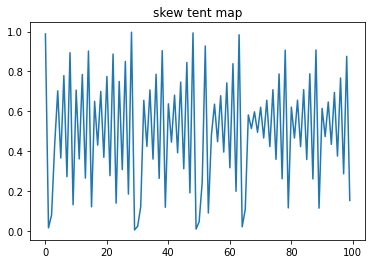

In [14]:
plt.title('skew tent map')
plt.plot(skew_tent_map(x0=np.random.uniform())[:100]);

#### Logistic map

$ x_{t+1} = r x_t(1-x_t) $

In [15]:
def logistic_map(n=2**15, r=4, x0=0.4):
    """
    Iterates the logistic map.
    Ott, E. Chaos in Dynamical Systems (Cambridge University Press, 2002).
    https://doi.org/10.1017/CBO9780511803260

    Parameters
    ----------
    n  : number of map iterations (length of the series).
    x0 : initial population ([0,1] interval)
    r  : intrinsic growth rate (r >= 0; interesting in [0,4] because then, it 
         maps the orbit to the [0,1] interval to itself.)
    ----------
    Returns a logistic map orbit.
    """
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
        
    return x

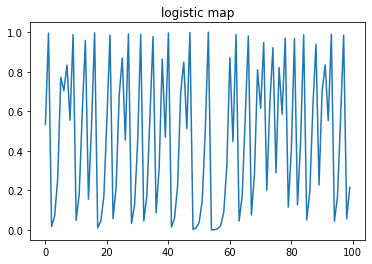

In [16]:
plt.title('logistic map')
plt.plot(logistic_map(x0=np.random.uniform())[:100]);

#### Schuster's map

The Schuster map, which exhibits intermittent signals with a power spectrum $P(f)∼1/f^z$.  
It is defined as:
$x_{t+1} = x_t + x^z _t \; \mathrm {(mod1)}$

In [17]:
def schuster_map(n=2**15, z=3/2, x0=.5):
    """
    Schuster, H.G.; Just, W. Deterministic Chaos: An Introduction; John Wiley & Sons: Hoboken, NJ, USA, 2006.
    https://doi.org/10.1002/zamm.19860660810
    
    Parameters
    ----------
    n : time series length
    z :  map parameter
    ----------
    Returns an orbit of an iterated Schuster map.
    """
    z    = float(z)
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    
    return x

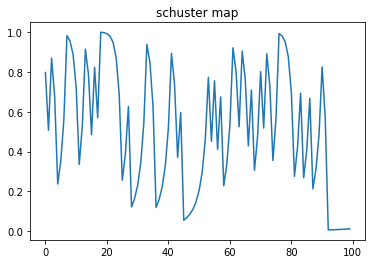

In [18]:
plt.title('schuster map')
plt.plot(schuster_map(x0=np.random.uniform())[:100]);

In [19]:
hc_lorenz = complexity_entropy(train_data, dx=dim)
hc_stentmap = np.mean([complexity_entropy(skew_tent_map(x0=np.random.uniform()), dx=dim) for _ in range(10)], axis=0)
hc_logistic = np.mean([complexity_entropy(logistic_map(x0=np.random.uniform()), dx=dim) for _ in range(10)], axis=0)
hc_schuster = np.mean([complexity_entropy(schuster_map(x0=np.random.uniform()), dx=dim) for _ in range(10)], axis=0)

### Regular time series generation

In [20]:
hc_linear = complexity_entropy(np.arange(0, 2**15), dx=dim)
hc_linear

(-0.0, -0.0)

In [21]:
start_time = 0
end_time = 10
time = np.arange(start_time, end_time, 1/10000)
frequency = 3
amplitude = 2
theta = 0
sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)
hc_sinewave = complexity_entropy(sinewave, dx=dim)
hc_sinewave

(0.10870776212538942, 0.10739087594835733)

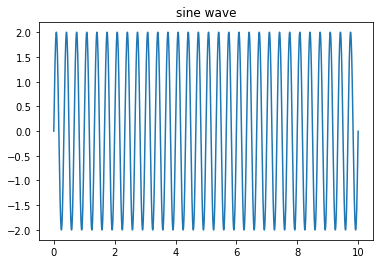

In [45]:
plt.title('sine wave')
plt.plot(time, sinewave);

### Stochastic time series generation

In [22]:
def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1;

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f):
    return f;

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

In [23]:
hc_white_noise = np.mean([complexity_entropy(white_noise(2**15), dx=dim) for _ in range(10)], axis=0)
hc_blue_noise = np.mean([complexity_entropy(blue_noise(2**15), dx=dim) for _ in range(10)], axis=0)
hc_violet_noise = np.mean([complexity_entropy(violet_noise(2**15), dx=dim) for _ in range(10)], axis=0)
hc_brownian_noise = np.mean([complexity_entropy(brownian_noise(2**15), dx=dim) for _ in range(10)], axis=0)
hc_pink_noise = np.mean([complexity_entropy(pink_noise(2**15), dx=dim) for _ in range(10)], axis=0)

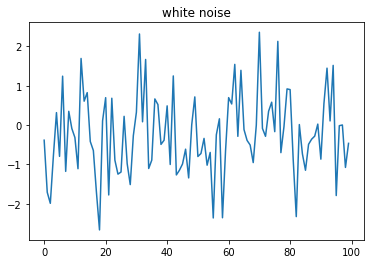

In [24]:
plt.title('white noise')
plt.plot(white_noise(2**15)[:100]);

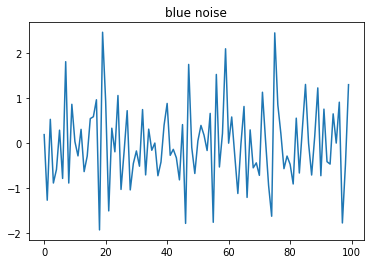

In [25]:
plt.title('blue noise')
plt.plot(blue_noise(2**15)[:100]);

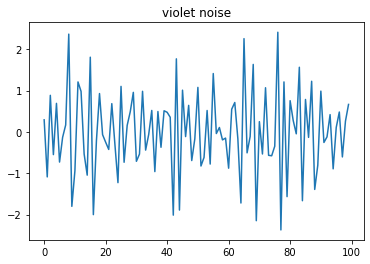

In [26]:
plt.title('violet noise')
plt.plot(violet_noise(2**15)[:100]);

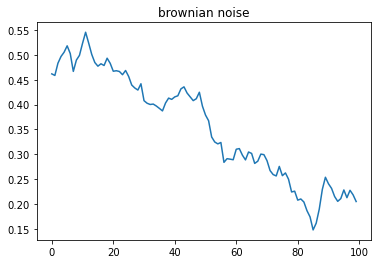

In [27]:
plt.title('brownian noise')
plt.plot(brownian_noise(2**15)[:100]);

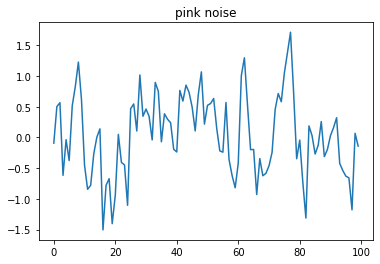

In [28]:
plt.title('pink noise')
plt.plot(pink_noise(2**15)[:100]);

### Financial time series

In [35]:
with open("tickers_list_total.txt", "r") as fp:
     tickers_list_total = json.load(fp)
all_tickers = tickers_list_total[0]
len(all_tickers)

8248

In [36]:
old_tickers = []
for i in tqdm(range(len(all_tickers))):
    ticker_name = all_tickers[i]
    parent_dir_one_min = 'C:/Users/Design/Downloads/HSE Time series/Lab1/complexity_entropy/all_tickers_daily_adj'
    path_dir = os.path.join(parent_dir_one_min, ticker_name)
    file = os.path.join(path_dir, ticker_name + '_daily_adj' + '.csv')
    df_daily = pd.read_csv(file)
    if len(df_daily)>=3000:
        old_tickers.append(ticker_name)

100%|█████████████████████████████████████████████████████████████████████████████| 8248/8248 [00:21<00:00, 375.86it/s]


In [37]:
len(old_tickers)

2761

In [27]:
long_ts = []
for i in tqdm(range(len(old_tickers))):
    ticker_name = old_tickers[i]
    parent_dir_one_min = 'C:/Users/Design/Downloads/HSE Time series/Lab1/complexity_entropy/all_tickers_daily_adj'
    path_dir = os.path.join(parent_dir_one_min, ticker_name)
    file = os.path.join(path_dir, ticker_name + '_daily_adj' + '.csv')
    df_daily = pd.read_csv(file)
    df_daily['date'] = pd.to_datetime(df_daily['Unnamed: 0'])
    df_daily = df_daily.sort_values(by='date', ascending=True)
    close_prices = df_daily['5. adjusted close']
    ts_scaler = TimeSeriesScalerMinMax()
    ftsclr = ts_scaler.fit_transform(close_prices.values.reshape(1, close_prices.values.shape[0])).ravel()
    ts_diff = np.diff(ftsclr)
    long_ts.append(ts_diff)

100%|█████████████████████████████████████████████████████████████████████████████| 2761/2761 [00:22<00:00, 122.57it/s]


In [29]:
#np.save('long_ts.npy', long_ts)
long_ts = np.load('long_ts.npy', allow_pickle=True).tolist()

In [30]:
hc_old_stocks = []
for i in tqdm(range(len(long_ts))):
    hc_ts = complexity_entropy(long_ts[i], dx=dim)
    hc_old_stocks.append([hc_ts[0], hc_ts[1]])

100%|██████████████████████████████████████████████████████████████████████████████| 2761/2761 [01:10<00:00, 39.36it/s]


### Complexity-entropy plane

In [31]:
def plot_borders(dim, figsize=(16,10)):
    arr1 = lower_bound_complexity_entropy(dx=dim, size=100)
    x1 = arr1[:,0]
    y1 = arr1[:,1]
    
    arr2 = upper_bound_complexity_entropy(dx=dim, size=1)
    x2 = np.hstack((arr2[:,0], 1))
    y2 = np.hstack((arr2[:,1], 0))
    x2_new = np.linspace(x2.min(), x2.max(), 10000)
    spline = make_interp_spline(x2, y2, k=2)
    y2_smooth = spline(x2_new)
    
    plt.figure(figsize=(16,10))
    plt.plot(x1,y1, color = 'dodgerblue', lw=3, linestyle='--', alpha=0.5)
    plt.plot(x2_new,y2_smooth, color = 'crimson', lw=3, linestyle='--', alpha=0.5)

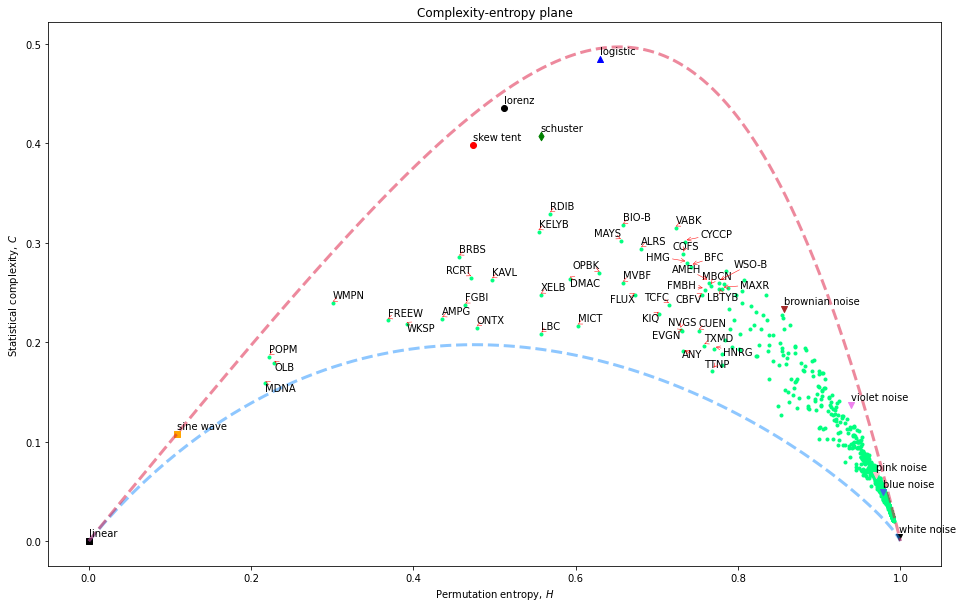

In [38]:
plot_borders(dim, figsize=(16,10))
texts=[]
for i, j in zip(old_tickers, hc_old_stocks):
    plt.scatter(j[0], j[1], c='springgreen', marker='.')
    if j[0]<0.78:
        texts.append(plt.text(j[0], j[1]+0.002, i))
        #plt.annotate(i, xy=(j[0], j[1]+0.002)) 
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5)) 
        
fig_name = ['lorenz','skew tent','logistic','schuster','white noise','blue noise','violet noise','brownian noise','pink noise','sine wave','linear']
hc_ = [hc_lorenz,hc_stentmap,hc_logistic,hc_schuster,hc_white_noise,hc_blue_noise,hc_violet_noise,hc_brownian_noise,hc_pink_noise,hc_sinewave, hc_linear]
сolor = ['black','red','blue','green','black','royalblue','violet','brown','pink','orange', 'black']
marker = ['o','o','^','d','v','v','v','v','v','s','s']
 
for i, j, k, l in zip(fig_name, hc_, сolor, marker):
    plt.scatter(j[0], j[1], c=k, marker=l)
    plt.annotate(i, xy=(j[0], j[1]+0.005))

plt.title('Complexity-entropy plane')    
plt.ylabel('Statistical complexity, $C$')
plt.xlabel('Permutation entropy, $H$')
plt.show()

<img src="theor_plane.jpg" width="400">

In [40]:
def plot_stock_price_hist(ticker_name, h, c):
    parent_dir_one_min = 'C:/Users/Design/Downloads/HSE Time series/Lab1/complexity_entropy/all_tickers_daily_adj'
    path_dir = os.path.join(parent_dir_one_min, ticker_name)
    file = os.path.join(path_dir, ticker_name + '_daily_adj' + '.csv')
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['Unnamed: 0'])
    df = df.sort_values(by='date', ascending=True)
    close_prices = df['5. adjusted close']
    plt.figure(figsize=(8,6))
    plt.title(ticker_name + ', ' + 'H=' + str(round(h,2)) + ', ' + 'C=' + str(round(c,2)))
    plt.plot(df['date'].values, close_prices, color = 'dodgerblue', lw=1)
    plt.ylabel('Adjusted close price, $')
    plt.show()

Рассмотрим акции компаний, что попали в области: stochastic, а также область между stochastic и strongly chaotic:

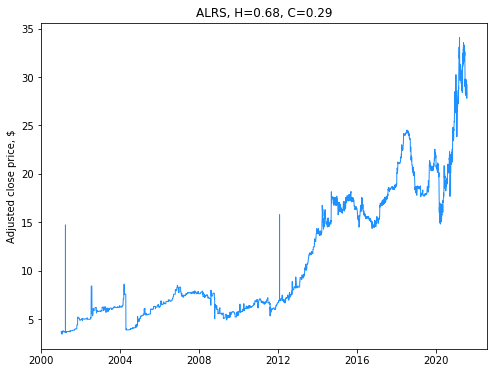

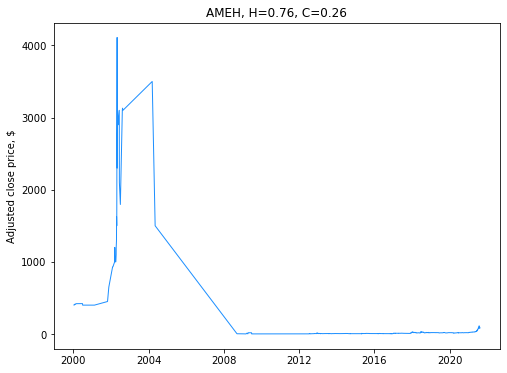

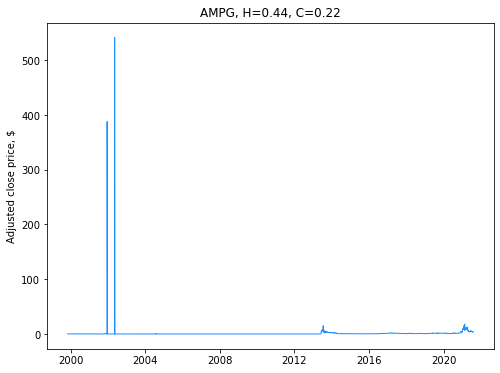

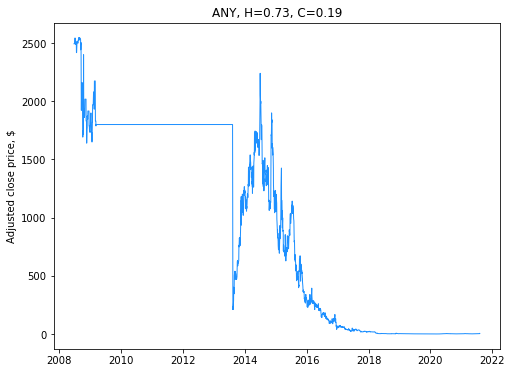

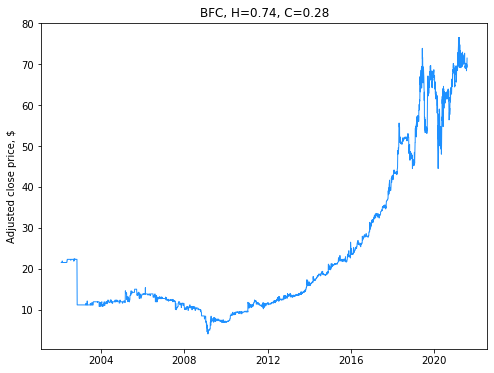

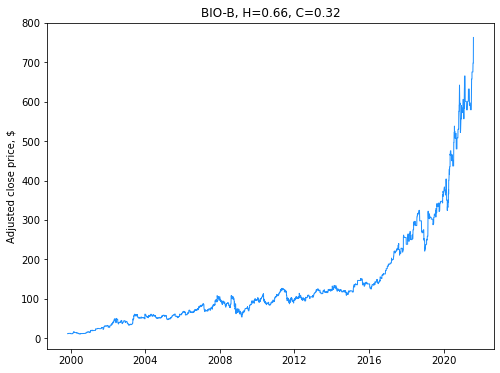

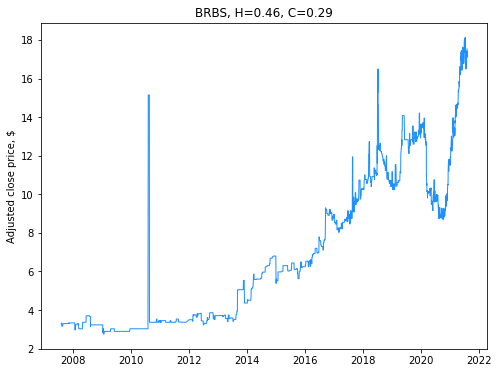

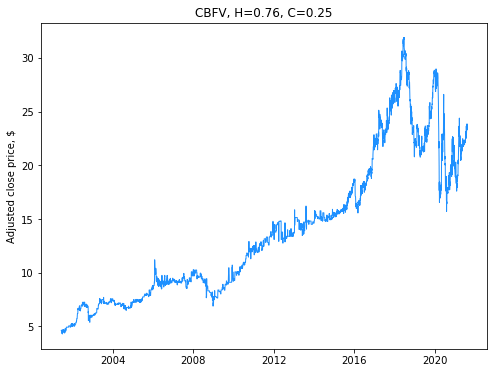

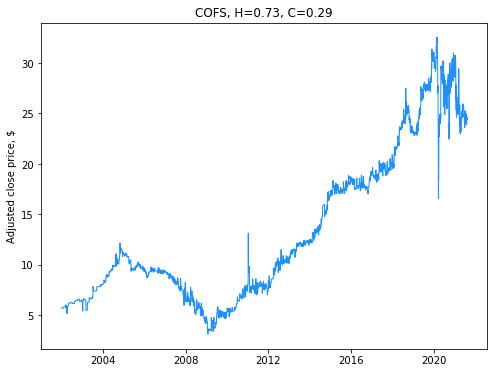

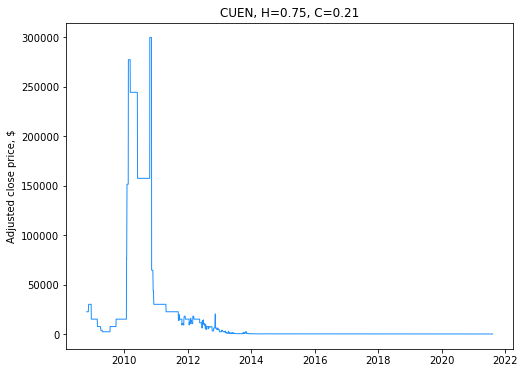

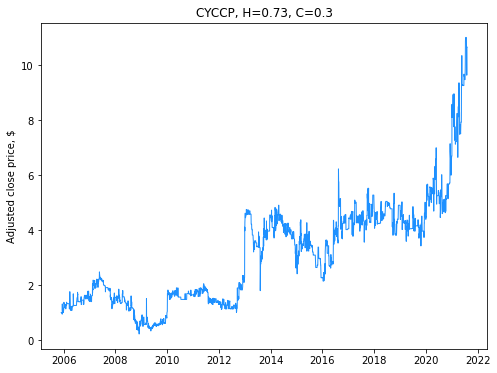

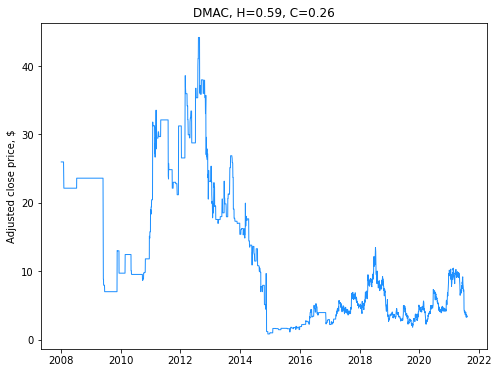

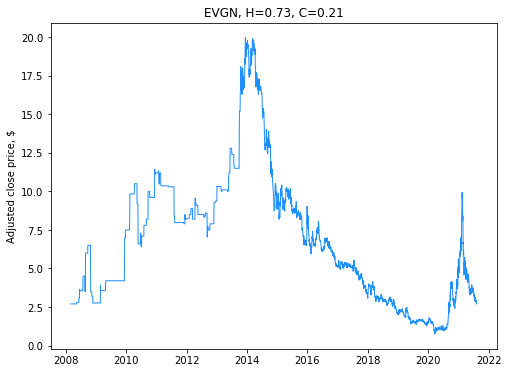

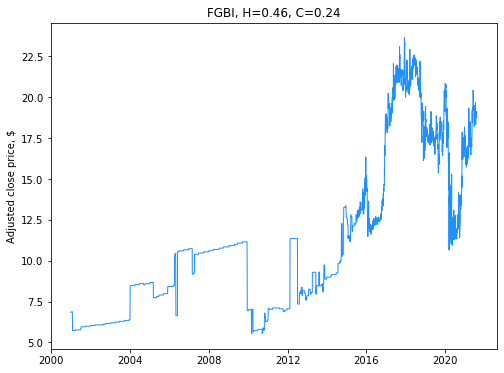

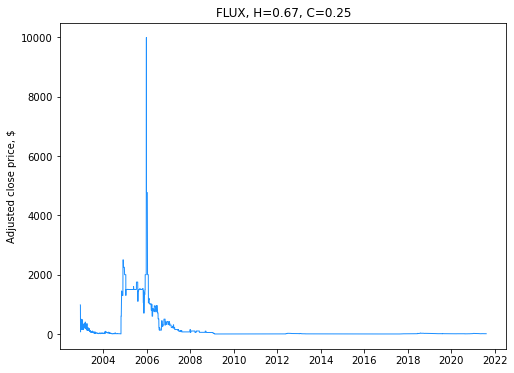

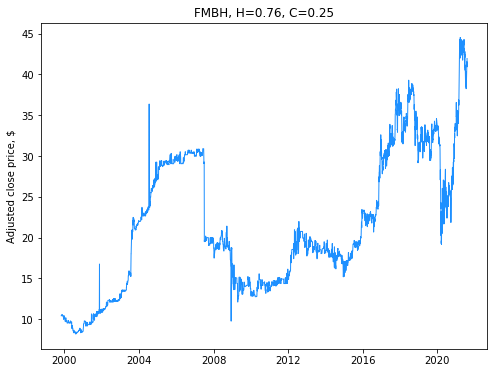

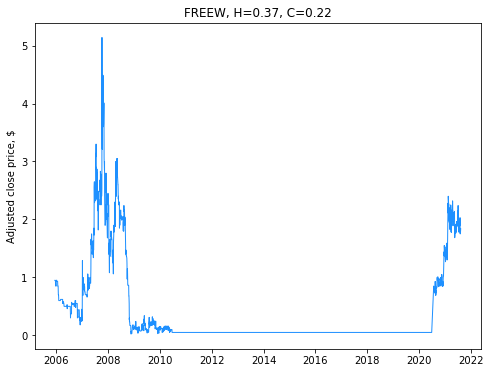

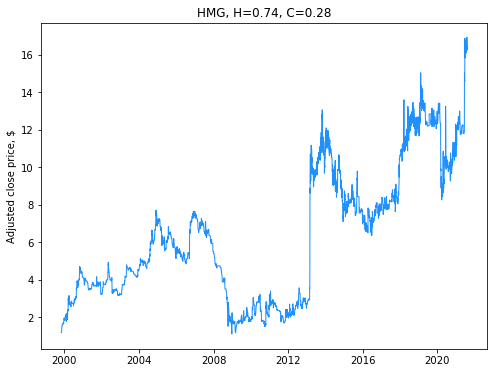

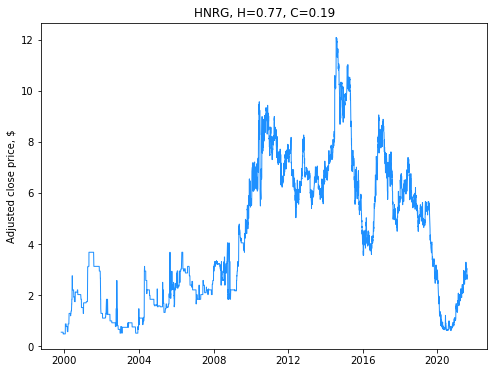

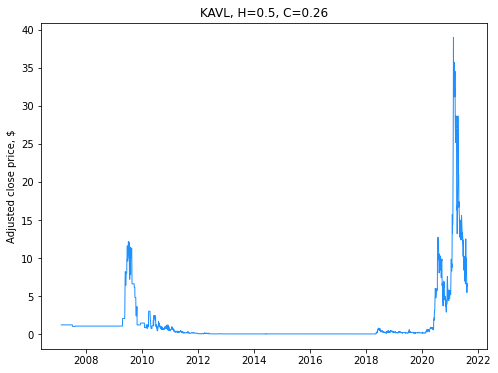

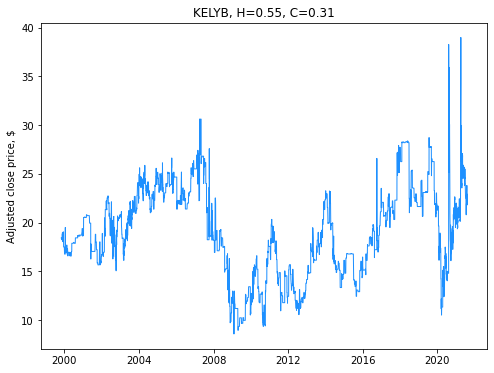

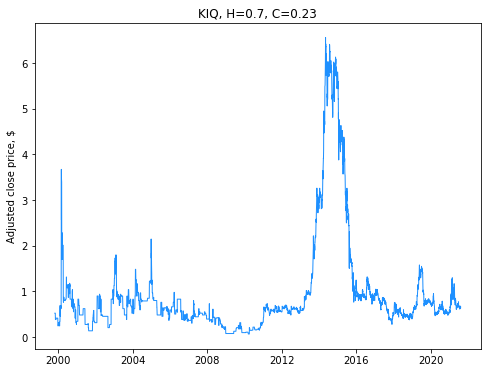

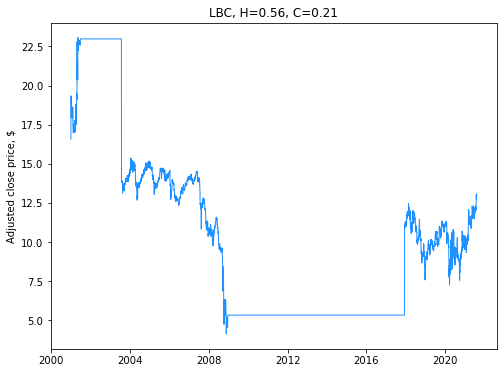

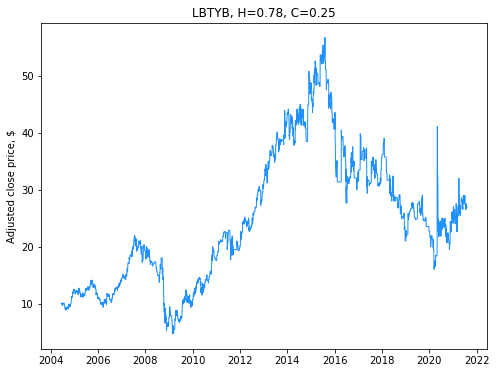

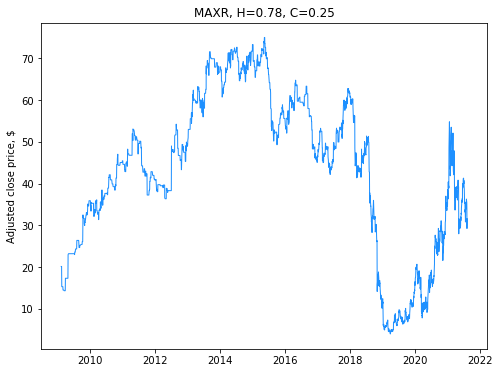

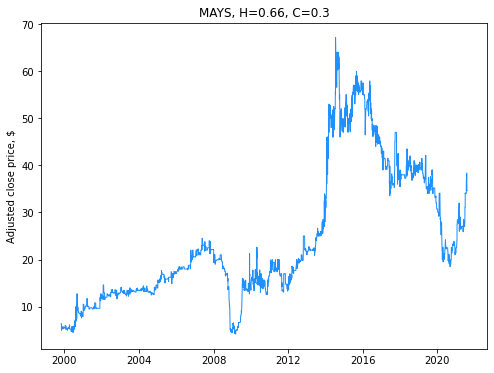

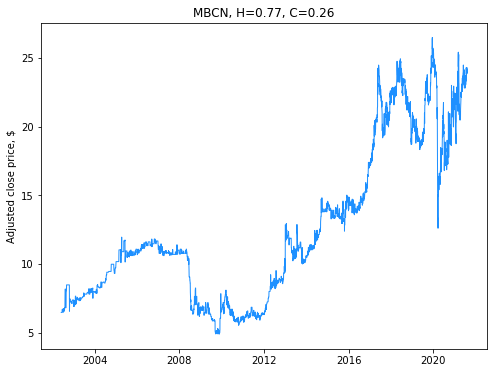

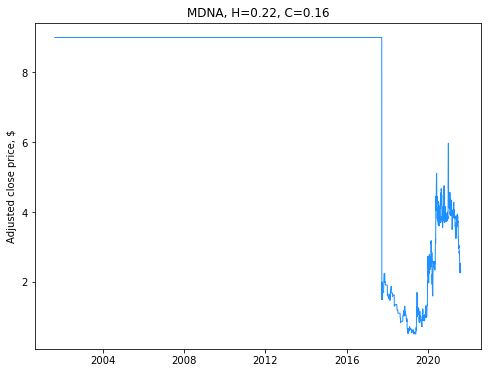

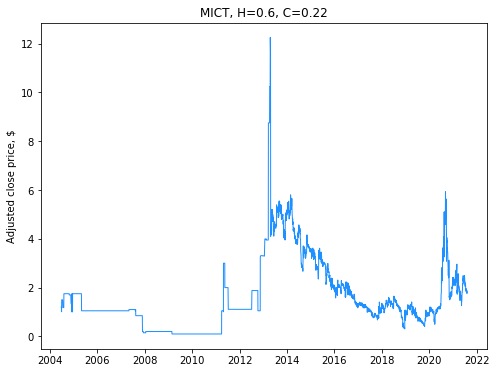

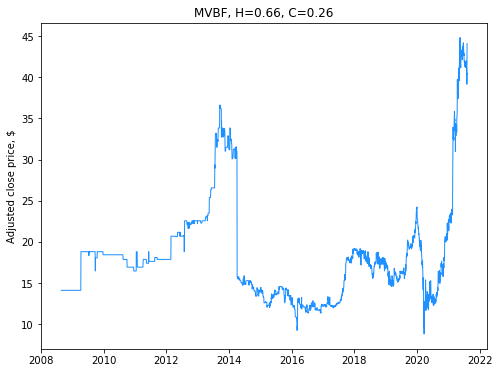

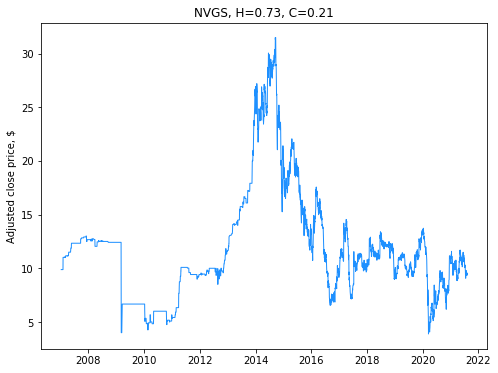

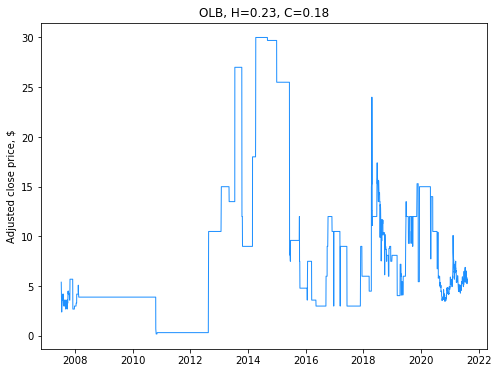

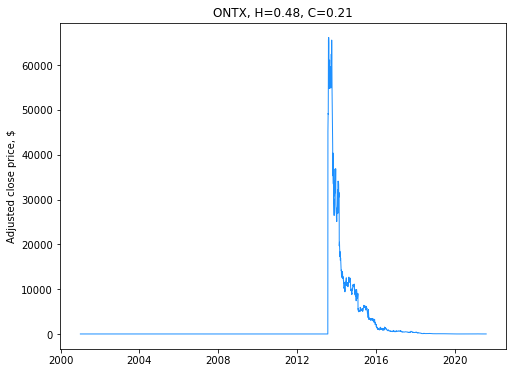

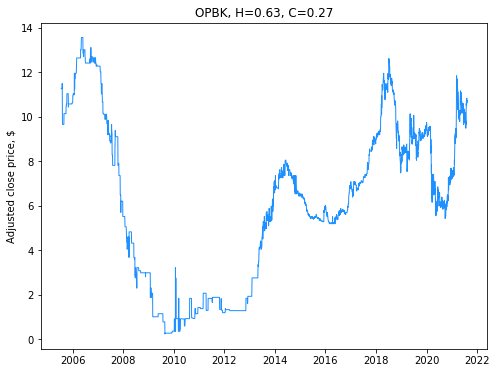

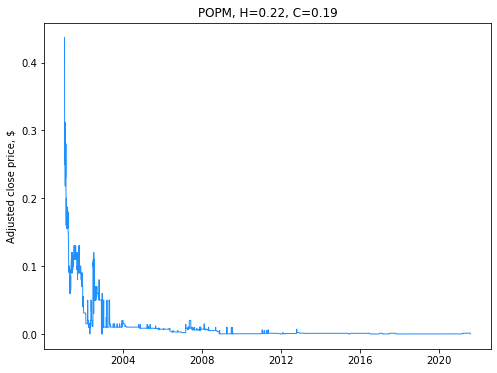

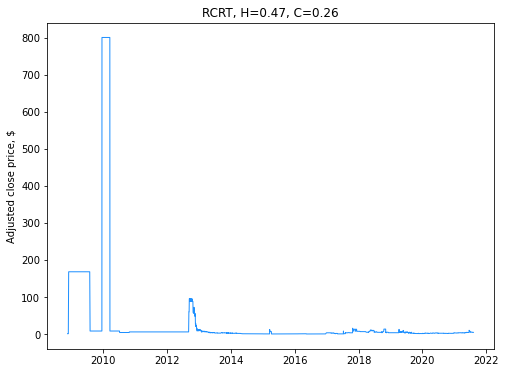

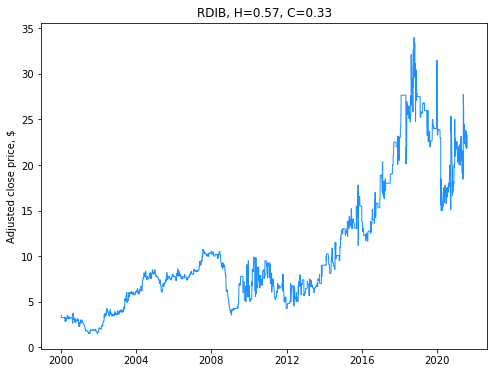

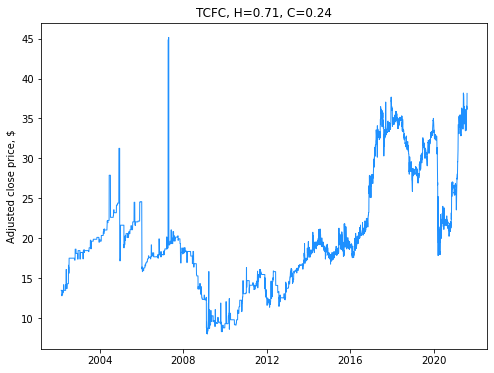

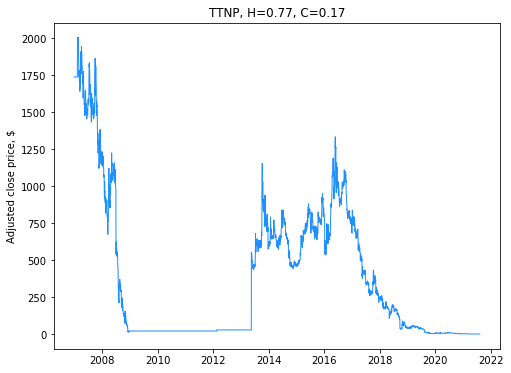

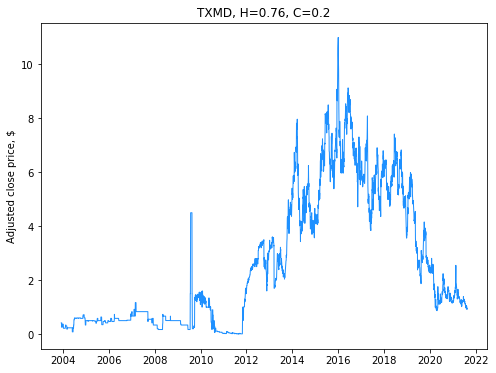

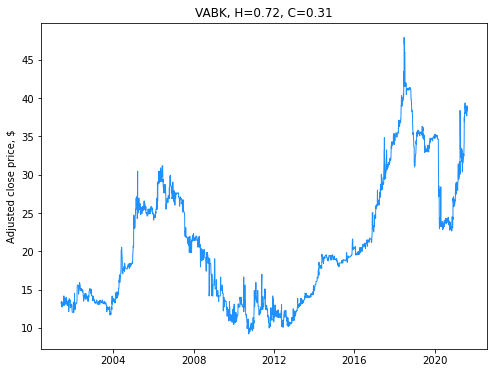

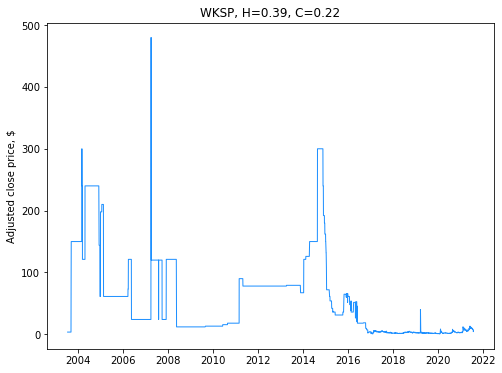

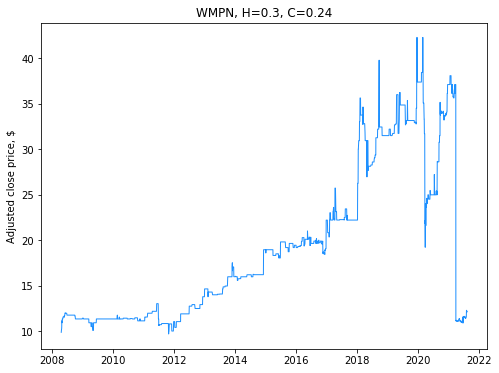

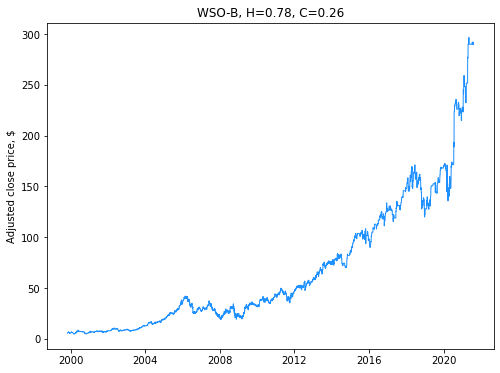

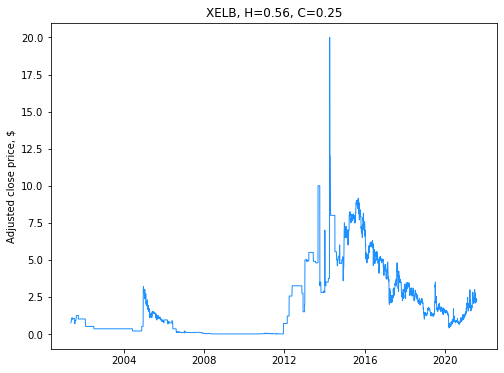

In [41]:
interesting_stocks = []
for i, j in zip(old_tickers, hc_old_stocks):
    if j[0]<0.78:
        interesting_stocks.append([i, j[0], j[1]])
for ticker, h, c in interesting_stocks:
    plot_stock_price_hist(ticker, h, c)

Из рассмотренных 45 рядов, permutation entropy которых ниже 0.78 (коэф. взят произвольно), только 12 выглядят активно торгуемыми, у остальных возникали проблемы с активным ценообразованием.
12 активных: ALRS, BFC, BIO-B, CBFV, COFS, CYCCP, HMG, MAXR, KIQ, LBTYB, VABK, WSO-B.

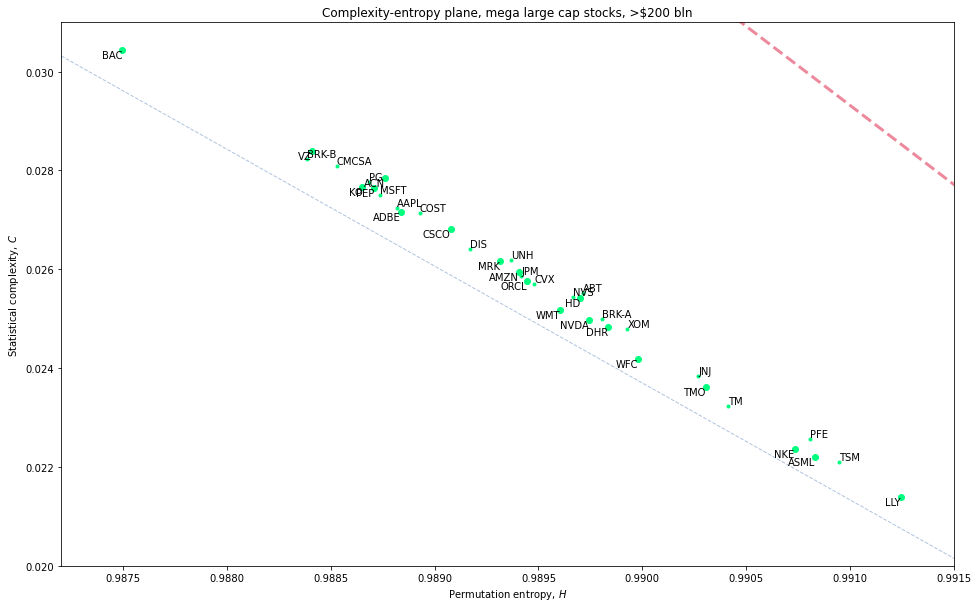

In [42]:
mega_large_caps = ['AAPL','MSFT','AMZN','NVDA','TSM','JPM','JNJ','UNH','WMT','BAC','HD', 'BRK-A', 'BRK-B',
                   'PG','ASML','DIS','ADBE','TM','XOM','ORCL','NKE','PFE','TMO','LLY','CSCO',
                   'CMCSA','KO','ACN','PEP','ABT','MRK','COST','DHR','CVX','VZ','WFC','NVS'] 
large_caps_hc = []
for i, j in zip(old_tickers, hc_old_stocks):
    if i in mega_large_caps:
        large_caps_hc.append([i, j[0], j[1]])
large_caps_hc_df = pd.DataFrame(large_caps_hc, columns =['ticker', 'h', 'c']).sort_values(by='h', ascending=True)
list1 = large_caps_hc_df.ticker.tolist()[0::2]
list2 = large_caps_hc_df.ticker.tolist()[1::2]

plot_borders(dim, figsize=(20,10))

for i, j in zip(old_tickers, hc_old_stocks):
    if i in list2:
        plt.scatter(j[0], j[1], c='springgreen', marker='.')
        plt.annotate(i, xy=(j[0], j[1]),
            horizontalalignment='left', verticalalignment='bottom')

for i, j in zip(old_tickers, hc_old_stocks):
    if i in list1:
        plt.scatter(j[0], j[1], c='springgreen', marker='o')
        plt.annotate(i, xy=(j[0], j[1]),
            horizontalalignment='right', verticalalignment='top')
        
plt.plot([hc_white_noise[0], hc_blue_noise[0]],[hc_white_noise[1], hc_blue_noise[1]], c='lightsteelblue', lw=1, linestyle='--')
plt.axis([0.9872, 0.9915, 0.02, 0.031])   
plt.title('Complexity-entropy plane, mega large cap stocks, >$200 bln')
plt.ylabel('Statistical complexity, $C$')
plt.xlabel('Permutation entropy, $H$')
plt.show()

Видим, что все mega large cap stocks лежат выше линии белый шум-синий шум (которая намного выше нижней теоретической границы энтропии-сложности), что говорит о том, что данные ряды (дневные цены) являются хаотическими с сильным шумом. Интересно наблюдать близкое расположение на плоскости KO и PEP, ASML и TSM, AMZN и ORCL, однако некоторые компании из других отраслей стоят немного ближе.